In [1]:
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import text


In [2]:
HOST = "172.18.0.7"
PORT = "5435"
USER = "moodle_sink"
PASS = "psqlpassword"
DB = "sink"
CONNECTION_STR = f"postgresql+psycopg2://{USER}:{PASS}@{HOST}/{DB}"
ENGINE = create_engine(CONNECTION_STR)




In [3]:
with ENGINE.connect() as conn:
    select_sites_users = 'SELECT * FROM "SitesUsers";'
    sites_users = pd.read_sql(sql=select_sites_users, con=conn)#, parse_dates=['registration_timestamp'])
    select_community_users = 'SELECT * FROM "CommunityUsers";'
    community_users = pd.read_sql(sql=select_community_users, con=conn)#, parse_dates=['registration_timestamp'])

# Data info

In [4]:
sites_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10872 entries, 0 to 10871
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10872 non-null  int64  
 1   username                10872 non-null  object 
 2   fullname                10872 non-null  object 
 3   admin_email             10872 non-null  object 
 4   registration_timestamp  10872 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 424.8+ KB


In [5]:
community_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41151 entries, 0 to 41150
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      41151 non-null  int64  
 1   username                41151 non-null  object 
 2   fullname                41151 non-null  object 
 3   email                   41151 non-null  object 
 4   registration_timestamp  41151 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.6+ MB


The main question I am trying to answer with this analysis are the following:

* Number of sites being registered weekly and its time evolution
* Number of users from Moodle Community administrating registered sites and its time evolution

To deal with the first question, I will need to be able to group the rows in a weekly manner. Pandas does allow me to extract the week of the year as an integer based on the date. But since the rows are across different years, I can't just use that number. I will prefix it with the year to have a unique grouping throughout my data.

In [6]:
sites_users['registration_timestamp'] = pd.to_datetime(sites_users['registration_timestamp'], unit="s")
community_users['registration_timestamp'] = pd.to_datetime(community_users['registration_timestamp'], unit="s")

# create a column with the years
sites_users['year'] = sites_users['registration_timestamp'].dt.year
community_users['year'] = community_users['registration_timestamp'].dt.year

sites_users["week_of_year"] = sites_users['registration_timestamp'].dt.isocalendar().week
community_users["week_of_year"] = community_users['registration_timestamp'].dt.isocalendar().week

sites_users["week_of_year"] = sites_users['year'].astype(str) + '_' + sites_users['week_of_year'].astype(str)
community_users["week_of_year"] = community_users['year'].astype(str) + '_' + community_users['week_of_year'].astype(str)

display(sites_users.head())
display(community_users.head())


,id,username,fullname,admin_email,registration_timestamp,year,week_of_year
0,1,brettwilkins,Kevin Horton,ericharris@hotmail.com,2010-04-14 21:23:29,2010,2010_15
1,2,dmiller,Jamie Brown,ahill@gmail.com,2011-07-08 17:07:04,2011,2011_27
2,3,susanberry,Todd Clements,ronald73@gmail.com,2010-12-10 15:13:16,2010,2010_49
3,4,mbrown,Dr. Stephanie Martin,kathrynhamilton@gmail.com,2015-11-11 10:54:44,2015,2015_46
4,5,lreyes,Belinda Hernandez,rebeccasoto@yahoo.com,2015-07-30 11:54:58,2015,2015_31


,id,username,fullname,email,registration_timestamp,year,week_of_year
0,1,bradleyalicia,Troy Wiley,amanda84@gmail.com,2013-09-15 16:22:23,2013,2013_37
1,2,lauriecrawford,John Ellis,lorili@yahoo.com,2013-04-16 20:41:23,2013,2013_16
2,3,paulamartinez,Francisco Moore,carrnicholas@gmail.com,2021-07-01 20:42:35,2021,2021_26
3,4,graywilliam,Robert Davis,hayesjason@gmail.com,2010-03-13 03:38:55,2010,2010_10
4,5,sierra30,Olivia Hughes,drichards@hotmail.com,2012-06-06 02:21:02,2012,2012_23


Now, all that is left to do is perform a group by and aggregate.

<AxesSubplot: title={'center': 'Site Users Count Per Week of Year'}, xlabel='week_of_year', ylabel='Users Count'>

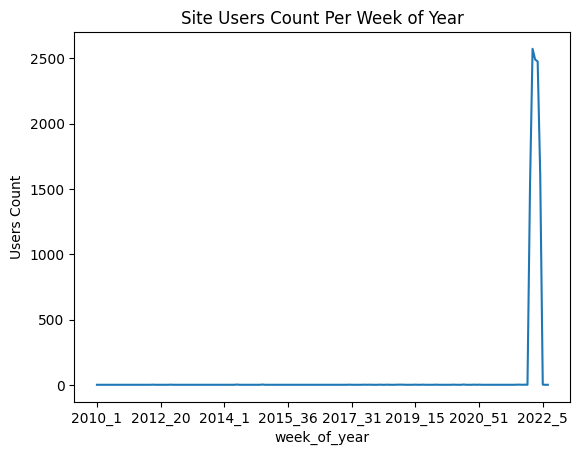

In [7]:
sites_users.groupby("week_of_year")["id"].count().plot(kind="line", title="Site Users Count Per Week of Year", ylabel="Users Count")

Since the most recent data is being continuously generated, the count shows a lot more registrations on the right side. 

<AxesSubplot: title={'center': 'Site Users Count Per Year'}, xlabel='year', ylabel='Users Count'>

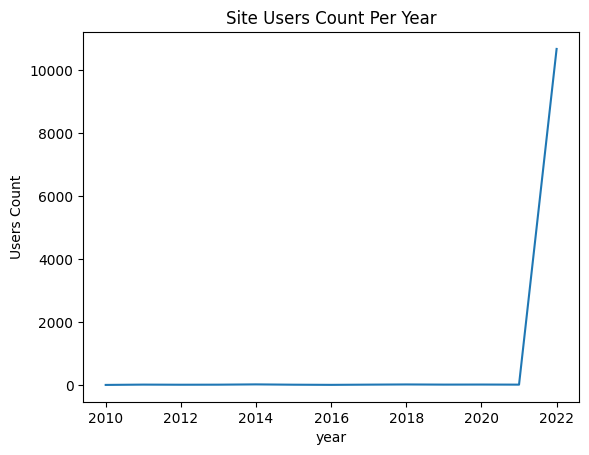

In [8]:
sites_users.groupby("year")["id"].count().plot(kind="line", title="Site Users Count Per Year", ylabel="Users Count")


The same trend can be seen when we group by year. Next, I will filter out the year 2022 and see the rugged graph we get.

<AxesSubplot: title={'center': 'Site Users Count Per Week of Year'}, xlabel='week_of_year', ylabel='Users Count'>

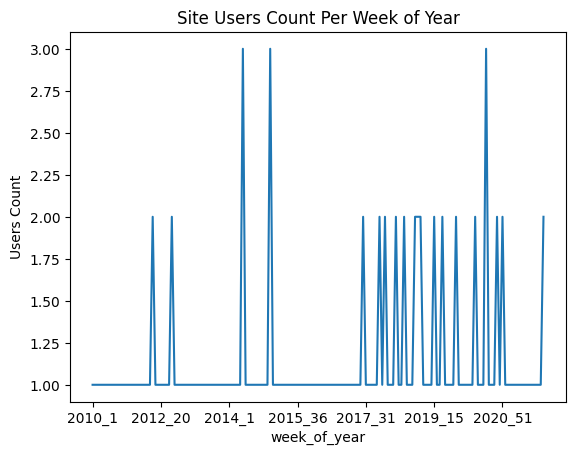

In [9]:
sites_users[sites_users["year"]!=2022].groupby("week_of_year")["id"].count().plot(kind="line", title="Site Users Count Per Week of Year", ylabel="Users Count")

This proves that my method of aggrigation does indeed answer the first question. Now giving a number like the average users that join every week based on this data will not be useful, but I have added it below here. I am using the data without 2022 added to remove the bias that might come from the data generator continuing to create new 2022 entries. 

In [10]:
sites_users[sites_users["year"]!=2022].groupby("week_of_year")["id"].count().mean()

1.1385542168674698

When I add 2022 back the avg count changes significantly.

In [11]:
sites_users.groupby("week_of_year")["id"].count().mean()


61.07865168539326

The second question asks, Number of users from Moodle Community administrating registered sites and its time evolution 

In [12]:
fourm_member_admins = sites_users[sites_users['admin_email'].isin(community_users['email'])]

In [13]:
fourm_member_admins.shape

(1360, 7)

In [14]:
fourm_member_admins.head()

,id,username,fullname,admin_email,registration_timestamp,year,week_of_year
6,7,matthewbryan,Brandon Lopez,ymorris@yahoo.com,2015-12-14 06:34:47,2015,2015_51
12,13,diana77,Clarence Gregory,jordankaren@gmail.com,2021-06-30 23:07:06,2021,2021_26
30,31,hreyes,Christopher Ballard,acox@hotmail.com,2014-05-27 20:11:53,2014,2014_22
82,83,reynoldsandrew,Sarah Walker,nicole13@hotmail.com,2014-03-05 22:07:29,2014,2014_10
87,88,cortiz,Jason Mccoy,mendezaustin@hotmail.com,2012-11-26 14:48:27,2012,2012_48


<AxesSubplot: title={'center': 'Site Admins that are also community users'}, xlabel='week_of_year', ylabel='count'>

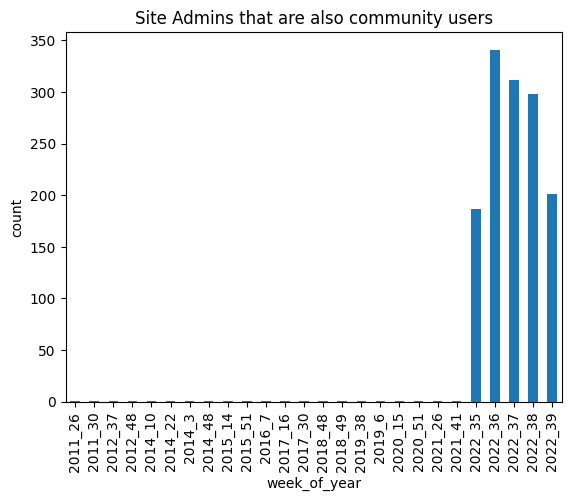

In [15]:
fourm_member_admins.groupby("week_of_year")["admin_email"].count().plot(kind="bar", title="Site Admins that are also community users", ylabel="count")